# BERTによる日本語ニュースタイトルの判別

#  Extracting fixed feature vectors of Japanese news by BERT

## 1. Import library　（ライブラリの取得）

In [0]:
import tensorflow as tf
import pandas as pd
import os
import re
import sys
import time
import numpy as np

from pathlib import Path
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook
from tensorflow.keras import backend as K

In [0]:
!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo
if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']

# import python modules defined by BERT
import modeling
import optimization
import tokenization
from tokenization import FullTokenizer

# import tfhub 
import tensorflow_hub as hub

# Initialize session
sess = tf.Session()

# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1"
max_seq_length = 50



Cloning into 'bert_repo'...
remote: Enumerating objects: 336, done.
remote: Total 336 (delta 0), reused 0 (delta 0), pack-reused 336
Receiving objects: 100% (336/336), 290.23 KiB | 430.00 KiB/s, done.
Resolving deltas: 100% (184/184), done.



## 2. Load livedoor-news-data　（ライブドアニュースデータの取得）


livedoor news corpus    CC BY-ND 2.1 JP　　　https://www.rondhuit.com/download.html#ldcc

In [0]:
train_df = pd.read_csv("train5.tsv", delimiter='\t', header=None, names=['label', 'title'])
dev_df = pd.read_csv("dev5.tsv", delimiter='\t', header=None, names=['label', 'title'])

In [0]:
train_df=train_df.loc[:, ['title','label']]
train_df=train_df.rename({'title':'sentence','label':'polarity'},axis='columns')
train_df.head() 

,sentence,polarity
0,"月額1,050円でSASディスクを搭載！クラウドプラン 「エクスライト（EX-LITE）」の...",0
1,例のあのメニューも！ニコニコ超会議のフードコートメニュー14種類紹介（前半）,0
2,山田孝之と小西真奈美の映画に撮影していない“あるモノ”が映り込んでいた,1
3,ガガを聴きながら毎朝歯磨き！ レディー・ガガ シンギングトゥースブラシ独占先行販売,0
4,斎藤佑樹はプロで通用するのか？,2


In [0]:
dev_df=dev_df.loc[:, ['title','label']]
dev_df=dev_df.rename({'title':'sentence','label':'polarity'},axis='columns')
dev_df.head(20) 

,sentence,polarity
0,ドコモのｓｐモードでまたトラブル発生！ 今度はつながらない【話題】,4
1,ダルビッシュ、今季だけで3つの魔球体得へ,2
2,本格的に仕事復帰、マリエが今一番会いたい人は“スギちゃん”,1
3,価格が安価で矯正を気づかれない！綺麗な歯並びになれる、歯列矯正の最前線,0
4,先輩・桑田、松井秀喜にズバリ「引退とかは考えなかった？」,2
5,【モテる家電】誰でもかっこよくなれる！ 男の正しい眉整え術,4
6,【オトナ女子のリアルな悩み】最長で半年…恋愛が長続きしない理由は？,3
7,虐待だ！の声多数、日テレで人気のワンコが声帯除去手術を受けていた事実に非難殺到【話題】,4
8,1枚で主食＋デザートに!? 宅配ピザ最前線「モッチリーノ」のお得なおいしさ,3
9,スマホで花咲く恋もある!? 合コンで使える本当の“モテテク”,3


In [0]:
# Create datasets (Only take up to max_seq_length words for memory)
train_text = train_df['sentence'].tolist()
train_text = [t[0:max_seq_length] for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = train_df['polarity'].tolist()

test_text = dev_df['sentence'].tolist()
test_text = [t[0:max_seq_length] for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = dev_df['polarity'].tolist()

## 3. Tokenize texts　（テキストをトークン化）


In [0]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=max_seq_length):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=max_seq_length):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples
  
  

# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_label)
test_examples = convert_text_to_examples(test_text, test_label)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## 4.  Create bert_inputs and extract embedding vectors　（学習データ準備と特徴量ベクトルの取得）

In [0]:
bert_inputs = dict(
    input_ids=train_input_ids,
    input_mask=train_input_masks,
    segment_ids=train_segment_ids)

bert_inputs

{'input_ids': array([[  101,  4460,  8399, ...,     0,     0,     0],
        [  101,  2280,  1946, ...,     0,     0,     0],
        [  101,  3504,  5610, ...,     0,     0,     0],
        ...,
        [  101,  1894,  1993, ...,     0,     0,     0],
        [  101,  2108,  3504, ...,     0,     0,     0],
        [  101,  1904, 27058, ...,     0,     0,     0]]),
 'input_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'segment_ids': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])}

In [0]:
BERT_PRETRAINED_DIR='/content/multi_cased_L-12_H-768_A-12'

In [0]:
bert_module = hub.Module("https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1", trainable=False)


t = time.time() 

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  bert_outputs = session.run(bert_module(bert_inputs, signature="tokens", as_dict=True))
  

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

  

pooled_output = bert_outputs["pooled_output"]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


23.33557 Seconds to predict


In [0]:
pooled_output = bert_outputs["pooled_output"]
print(pooled_output.shape)
pooled_output

(3503, 768)


array([[ 0.3309436 ,  0.00226622,  0.32829154, ..., -0.38312903,
         0.20412014,  0.24579671],
       [ 0.3761179 , -0.08474827,  0.3083133 , ..., -0.23839965,
         0.20487733,  0.16242261],
       [ 0.39279824, -0.17144825,  0.3055103 , ..., -0.47528458,
         0.24804759,  0.24116465],
       ...,
       [ 0.43240264,  0.0924272 ,  0.335994  , ..., -0.42362997,
         0.2150477 ,  0.11122324],
       [ 0.4047562 ,  0.04343599,  0.23401332, ..., -0.18150674,
         0.08990362,  0.10266227],
       [ 0.43208814, -0.16266493,  0.30272773, ..., -0.33386657,
         0.29739577,  0.28396413]], dtype=float32)

##  5. Create bert_test and extract embedding vectors （テストデータ準備と特徴量ベクトルの取得）

In [0]:
bert_test = dict(
    input_ids=test_input_ids,
    input_mask=test_input_masks,
    segment_ids=test_segment_ids)

bert_test

{'input_ids': array([[  101,   100,  5712, ...,     0,     0,     0],
        [  101,  2015, 12434, ...,     0,     0,     0],
        [  101,  4476,  4580, ...,     0,     0,     0],
        ...,
        [  101,  4854,  1980, ...,     0,     0,     0],
        [  101,   148, 11490, ...,     0,     0,     0],
        [  101,  4476,  2251, ...,     0,     0,     0]]),
 'input_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'segment_ids': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])}

In [0]:
t = time.time() 

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  bert_outputs2 = session.run(bert_module(bert_test, signature="tokens", as_dict=True))
  

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


8.02823 Seconds to predict


In [0]:
pooled_output2 = bert_outputs2["pooled_output"]
pooled_output2

array([[ 0.2525362 ,  0.06495357,  0.28061128, ..., -0.17444399,
         0.21893732,  0.02746354],
       [ 0.313074  , -0.03618057,  0.24547501, ..., -0.2627668 ,
         0.14594312,  0.10071174],
       [ 0.2933037 , -0.0561114 ,  0.36557734, ..., -0.3451954 ,
         0.26619253,  0.06667353],
       ...,
       [ 0.35316917,  0.03228869,  0.30559295, ..., -0.04534116,
         0.27333385,  0.0794063 ],
       [ 0.3793611 , -0.0408264 ,  0.30807894, ..., -0.16299908,
         0.29364216,  0.24983822],
       [ 0.26637638, -0.14480321,  0.23917615, ..., -0.13616638,
         0.05432262,  0.09414483]], dtype=float32)

In [0]:
x_train=pooled_output
x_test=pooled_output2

y_train=train_labels
y_test=test_labels

In [0]:
print(type(y_train))
print(np.shape(y_train))
print(type(y_test))
print(np.shape(y_test))

<class 'numpy.ndarray'>
(3503, 1)
<class 'numpy.ndarray'>
(876, 1)


In [0]:
input = tf.keras.Input(shape=(768,))
x = tf.keras.layers.Dense(8, activation='relu')(input)
pred = tf.keras.layers.Dense(5, activation='softmax')(x) 

model=tf.keras.Model(inputs=input, outputs=pred)
model.summary()
  

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6152      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
Total params: 6,197
Trainable params: 6,197
Non-trainable params: 0
_________________________________________________________________


## 6. Train and evaluate model for classification task (カテゴリ判別モデルの訓練と評価)

In [0]:
  model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ), metrics=['accuracy'])

In [0]:
t = time.time() 

history = model.fit(x_train, y_train ,
                    batch_size=32,
                    epochs=200,
                    verbose=1,
                    validation_data=(x_test, y_test)
                       )

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

Train on 3503 samples, validate on 876 samples
Epoch 1/200
3503/3503 [==============================] - 1s 359us/sample - loss: 1.5447 - acc: 0.2952 - val_loss: 1.4933 - val_acc: 0.3082
Epoch 2/200
3503/3503 [==============================] - 0s 74us/sample - loss: 1.4443 - acc: 0.4131 - val_loss: 1.4069 - val_acc: 0.4110
Epoch 3/200
3503/3503 [==============================] - 0s 76us/sample - loss: 1.3420 - acc: 0.5073 - val_loss: 1.2434 - val_acc: 0.5719
Epoch 4/200
3503/3503 [==============================] - 0s 72us/sample - loss: 1.1326 - acc: 0.6212 - val_loss: 1.0420 - val_acc: 0.6587
Epoch 5/200
3503/3503 [==============================] - 0s 69us/sample - loss: 0.9575 - acc: 0.6803 - val_loss: 0.9213 - val_acc: 0.6918
Epoch 6/200
3503/3503 [==============================] - 0s 72us/sample - loss: 0.8666 - acc: 0.7005 - val_loss: 0.8567 - val_acc: 0.7043
Epoch 7/200
3503/3503 [==============================] - 0s 73us/sample - loss: 0.8023 - acc: 0.7171 - val_loss: 0.8158 - va

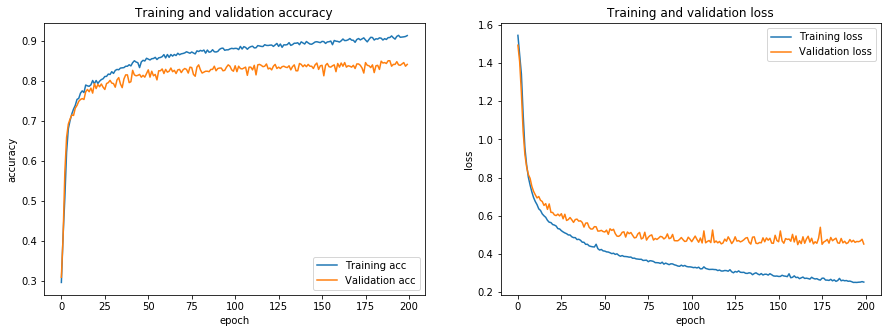

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
            
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()